## Multi Agent - Langgraph and Bedrock Agent

##### Load the environment variables

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv('TAVILY_API_KEY')
model_id = os.getenv('MODEL_ID')
aws_region = os.getenv('AWS_REGION')
bedrock_kb_id = os.getenv('BEDROCK_KB_ID')
bedrock_agent_id = os.getenv('BEDROCK_AGENT_ID')
bedrock_agent_alias_id = os.getenv('BEDROCK_AGENT_ALIAS_ID')

##### Model

In [ ]:
## Model - Agent Brain
from langchain_aws import ChatBedrock
llm = ChatBedrock(model=model_id)

##### Agent State

In [2]:
from typing import TypedDict

class MultiAgentState(TypedDict):
    question: str
    question_type: str
    answer: str
    feedback: str

In [3]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

def rewrite_node(state: MultiAgentState):
    """
   REwrite question from query to match domain expert
    Args:
        question (str): The user query
    Returns:
        promt (str): rewrite question to form an expert prompt
    """
    print("---REWRITE QUESTION---")
    c3_template = """Rewrite the question by following the {{instruction}} to capture more precise and comprehensive intent from {question}.
    <instructions> 
        <step>Identify the key purposes, concepts and entities in the original {{question}}.</step> 
        <step>Rephrase the question to be more specific and focused, ensuring that the language is clear and unambiguous.</step> 
        <step>Provide additional context or background information that may be helpful for web search or RAG system to better understand and respond to the question.</step> 
        <step>Output your reqritten question only without answering it or repeating the riginal one.</step>
    </instructions> 
    """
    
    c3_prompt = ChatPromptTemplate.from_template(c3_template)
    #chain = ( c3_prompt | llm_c3 | StrOutputParser() | (lambda x: x.split("\n")))
    rewritten_chain = ( c3_prompt | llm | StrOutputParser() )
    rewritten_question = rewritten_chain.invoke({"question": state['question']})
    print(rewritten_question)

    return {"answer": rewritten_question}

In [4]:
#####
# Router agent
#####
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AnyMessage

question_category_prompt = '''You are a senior specialist of analytical support. Your task is to classify the incoming questions. 
Depending on your answer, question will be routed to the right team, so your task is crucial for our team. 
There are 3 possible question types: 
- Websearch- Answer questions based on events happened recently, after most LLM's cut-off dates. 
- General - Answer questions for LLM or a few LLMs.
- Agents - Any information related to AI Agents and Agents memory.
Return in the output only one word (WEBSEARCH, GENERAL, AGENTS).
'''

def router_node(state: MultiAgentState):
    print('Router node started execution')
    messages = [
        SystemMessage(content=question_category_prompt), 
        HumanMessage(content=state['question'])
    ]
    response = llm.invoke(messages)
    print('Question type: %s' % response.content)
    return {"question_type": response.content}

##### Langchain Agent

In [ ]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent

def search_expert_node(state: MultiAgentState):
    tavily_tool = TavilySearchResults(max_results=5)

    search_expert_system_prompt = '''
    You are an expert in LangChain and other technologies. 
    Your goal is to answer questions based on results provided by search.
    You don't add anything yourself and provide only information baked by other sources. 
    '''
    search_agent = create_react_agent(llm, [tavily_tool],
        state_modifier = search_expert_system_prompt)
    
    messages = [HumanMessage(content=state['question'])]
    result = search_agent.invoke({"messages": messages})
    return {'answer': result['messages'][-1].content}


##### Bedrock Agent

In [ ]:
import uuid
import logging
from datetime import datetime
import boto3

bedrock_agent_runtime_client = boto3.client(service_name='bedrock-agent-runtime', region_name = aws_region)

def invoke_BR_agent(agent_id, alias_id, query, enable_trace=False, session_state=dict()):
    session_id = str(uuid.uuid1())
    end_session = False
    
    # invoke the agent API
    agentResponse = bedrock_agent_runtime_client.invoke_agent(
        inputText=query,
        agentId=bedrock_agent_id,
        agentAliasId=bedrock_agent_alias_id, 
        sessionId=session_id,
        enableTrace=enable_trace, 
        endSession= end_session,
        sessionState=session_state
    )
    
    event_stream = agentResponse['completion']
    try:
        for event in event_stream:        
            if 'chunk' in event:
                data = event['chunk']['bytes']
                agent_answer = data.decode('utf8')
                end_event_received = True
                return agent_answer
                # End event indicates that the request finished successfully
            else:
                raise Exception("unexpected event.", event)
    except Exception as e:
        raise Exception("unexpected event.", e)

def bedrock_agent_node(state:MultiAgentState):
    today = datetime.today().strftime('%b-%d-%Y')
    session_state = {
        "promptSessionAttributes": {
            "name": "John Doe",
            "today": today
        }
    }
    return {'answer': invoke_BR_agent(bedrock_agent_id, bedrock_agent_alias_id, state["question"])}

##### Router

In [ ]:

def route_question(state: MultiAgentState):
    print('route function execution')
    print(state)
    return state['question_type']

##### Build the graph

In [12]:
from langgraph.graph import StateGraph, END

orch = StateGraph(MultiAgentState)
orch.add_node("rewrite", rewrite_node)
orch.add_node("router", router_node)
orch.add_node('search_expert', search_expert_node)
orch.add_node('agent_expert', bedrock_agent_node)

orch.set_entry_point("rewrite")
orch.add_edge('rewrite', 'router')
orch.add_conditional_edges('router', route_question, {
    "WEBSEARCH" : 'search_expert',
    "AGENTS" : 'agent_expert'
})
orch.add_edge('search_expert', END)
orch.add_edge('agent_expert', END)

##### Compile tha agent

In [14]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = orch.compile(checkpointer=memory)

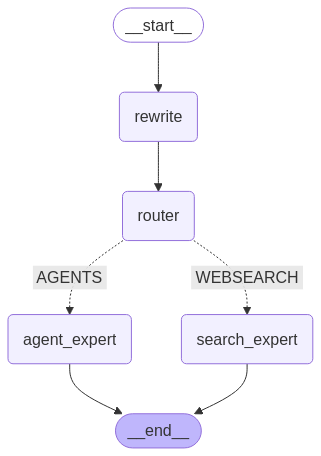

In [15]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod #, NodeColors

display(Image(graph.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    #node_colors=NodeColors(start="#ffdfba", end="#baffc9", other="#fad7de"),
    #node_styles=custom_node_style,
    wrap_label_n_words=9,
    output_file_path=None,
    draw_method=MermaidDrawMethod.API,
    background_color="white",
    padding=20,
)))

##### Run the agent

In [18]:
prompt = 'what are the types of agentic memory'
thread = {"configurable": {"thread_id": "42",  "recursion_limit": 10}}
for event in graph.stream({'question':prompt}, thread):
        print(event)

---REWRITE QUESTION---
What are the distinct types and characteristics of memory systems used in AI agents and autonomous systems, including their roles in learning, decision-making, and task execution? Include specific implementations such as episodic memory, working memory, and semantic memory in the context of artificial intelligence and cognitive architectures.
{'rewrite': {'answer': 'What are the distinct types and characteristics of memory systems used in AI agents and autonomous systems, including their roles in learning, decision-making, and task execution? Include specific implementations such as episodic memory, working memory, and semantic memory in the context of artificial intelligence and cognitive architectures.'}}
Router node started execution
Question type: AGENTS
route function execution
{'question_type': 'AGENTS', 'question': 'what are the types of agentic memory', 'answer': 'What are the distinct types and characteristics of memory systems used in AI agents and auto